# Weight Sampling Tutorial

If you want to fine-tune one of the trained original SSD models on your own dataset, chances are that your dataset doesn't have the same number of classes as the trained model you're trying to fine-tune.

This notebook explains a few options for how to deal with this situation. In particular, one solution is to sub-sample (or up-sample) the weight tensors of all the classification layers so that their shapes correspond to the number of classes in your dataset.

This notebook explains how this is done.

## 0. Our example

I'll use a concrete example to make the process clear, but of course the process explained here is the same for any dataset.

Consider the following example. You have a dataset on road traffic objects. Let this dataset contain annotations for the following object classes of interest:

`['car', 'truck', 'pedestrian', 'bicyclist', 'traffic_light', 'motorcycle', 'bus', 'stop_sign']`

That is, your dataset contains annotations for 8 object classes.

You would now like to train an SSD300 on this dataset. However, instead of going through all the trouble of training a new model from scratch, you would instead like to use the fully trained original SSD300 model that was trained on MS COCO and fine-tune it on your dataset.

The problem is: The SSD300 that was trained on MS COCO predicts 80 different classes, but your dataset has only 8 classes. The weight tensors of the classification layers of the MS COCO model don't have the right shape for your model that is supposed to learn only 8 classes. Bummer.

So what options do we have?

### Option 1: Just ignore the fact that we need only 8 classes

The maybe not so obvious but totally obvious option is: We could just ignore the fact that the trained MS COCO model predicts 80 different classes, but we only want to fine-tune it on 8 classes. We could simply map the 8 classes in our annotated dataset to any 8 indices out of the 80 that the MS COCO model predicts. The class IDs in our dataset could be indices 1-8, they could be the indices `[0, 3, 8, 1, 2, 10, 4, 6, 12]`, or any other 8 out of the 80. Whatever we would choose them to be. The point is that we would be training only 8 out of every 80 neurons that predict the class for a given box and the other 72 would simply not be trained. Nothing would happen to them, because the gradient for them would always be zero, because these indices don't appear in our dataset.

This would work, and it wouldn't even be a terrible option. Since only 8 out of the 80 classes would get trained, the model might get gradually worse at predicting the other 72 clases, but we don't care about them anyway, at least not right now. And if we ever realize that we now want to predict more than 8 different classes, our model would be expandable in that sense. Any new class we want to add could just get any one of the remaining free indices as its ID. We wouldn't need to change anything about the model, it would just be a matter of having the dataset annotated accordingly.

Still, in this example we don't want to take this route. We don't want to carry around the computational overhead of having overly complex classifier layers, 90 percent of which we don't use anyway, but still their whole output needs to be computed in every forward pass.

So what else could we do instead?

### Option 2: Just ignore those weights that are causing problems

We could build a new SSD300 with 8 classes and load into it the weights of the MS COCO SSD300 for all layers except the classification layers. Would that work? Yes, that would work. The only conflict is with the weights of the classification layers, and we can avoid this conflict by simply ignoring them. While this solution would be easy, it has a significant downside: If we're not loading trained weights for the classification layers of our new SSD300 model, then they will be initialized randomly. We'd still benefit from the trained weights for all the other layers, but the classifier layers would need to be trained from scratch.

Not the end of the world, but we like pre-trained stuff, because it saves us a lot of training time. So what else could we do?

### Option 3: Sub-sample the weights that are causing problems

Instead of throwing the problematic weights away like in option 2, we could also sub-sample them. If the weight tensors of the classification layers of the MS COCO model don't have the right shape for our new model, we'll just **make** them have the right shape. This way we can still benefit from the pre-trained weights in those classification layers. Seems much better than option 2.

The great thing in this example is: MS COCO happens to contain all of the eight classes that we care about. So when we sub-sample the weight tensors of the classification layers, we won't just do so randomly. Instead, we'll pick exactly those elements from the tensor that are responsible for the classification of the 8 classes that we care about.

However, even if the classes in your dataset were entirely different from the classes in any of the fully trained models, it would still make a lot of sense to use the weights of the fully trained model. Any trained weights are always a better starting point for the training than random initialization, even if your model will be trained on entirely different object classes.

And of course, in case you happen to have the opposite problem, where your dataset has **more** classes than the trained model you would like to fine-tune, then you can simply do the same thing in the opposite direction: Instead of sub-sampling the classification layer weights, you would then **up-sample** them. Works just the same way as what we'll be doing below.

Let's get to it.

In [1]:
import h5py
import numpy as np
import shutil

from misc_utils.tensor_sampling_utils import sample_tensors

## 1. Load the trained weights file and make a copy

First, we'll load the HDF5 file that contains the trained weights that we need (the source file). In our case this is "`VGG_coco_SSD_300x300_iter_400000.h5`" (download link available in the README of this repo), which are the weights of the original SSD300 model that was trained on MS COCO.

Then, we'll make a copy of that weights file. That copy will be our output file (the destination file).

In [2]:
# TODO: Set the path for the source weights file you want to load.
dataFolder = '../Models/'

weights_source_path = dataFolder + 'VGG_coco_SSD_300x300_iter_400000.h5'

# TODO: Set the path and name for the destination weights file
#       that you want to create.

weights_destination_path = dataFolder + 'VGG_coco_SSD_300x300_iter_400000_subsampled_3_classes3.h5'

# Make a copy of the weights file.
shutil.copy(weights_source_path, weights_destination_path)

'../Models/VGG_coco_SSD_300x300_iter_400000_subsampled_3_classes3.h5'

In [3]:
# Load both the source weights file and the copy we made.
# We will load the original weights file in read-only mode so that we can't mess up anything.
weights_source_file = h5py.File(weights_source_path, 'r')
weights_destination_file = h5py.File(weights_destination_path)

/home/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


## 2. Figure out which weight tensors we need to sub-sample

Next, we need to figure out exactly which weight tensors we need to sub-sample. As mentioned above, the weights for all layers except the classification layers are fine, we don't need to change anything about those.

So which are the classification layers in SSD300? Their names are:

In [4]:
classifier_names = ['conv4_3_norm_mbox_conf',
                    'fc7_mbox_conf',
                    'conv6_2_mbox_conf',
                    'conv7_2_mbox_conf',
                    'conv8_2_mbox_conf',
                    'conv9_2_mbox_conf']

## 3. Figure out which slices to pick

The following section is optional. I'll look at one classification layer and explain what we want to do, just for your understanding. If you don't care about that, just skip ahead to the next section.

We know which weight tensors we want to sub-sample, but we still need to decide which (or at least how many) elements of those tensors we want to keep. Let's take a look at the first of the classifier layers, "`conv4_3_norm_mbox_conf`". Its two weight tensors, the kernel and the bias, have the following shapes:

In [5]:
conv4_3_norm_mbox_conf_kernel = weights_source_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_source_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 324)
bias:	 (324,)


So the last axis has 324 elements. Why is that?

- MS COCO has 80 classes, but the model also has one 'backgroud' class, so that makes 81 classes effectively.
- The 'conv4_3_norm_mbox_loc' layer predicts 4 boxes for each spatial position, so the 'conv4_3_norm_mbox_conf' layer has to predict one of the 81 classes for each of those 4 boxes.

That's why the last axis has 4 * 81 = 324 elements.

So how many elements do we want in the last axis for this layer?

Let's do the same calculation as above:

- Our dataset has 8 classes, but our model will also have a 'background' class, so that makes 9 classes effectively.
- We need to predict one of those 9 classes for each of the four boxes at each spatial position.

That makes 4 * 9 = 36 elements.

Now we know that we want to keep 36 elements in the last axis and leave all other axes unchanged. But which 36 elements out of the original 324 elements do we want?

Should we just pick them randomly? If the object classes in our dataset had absolutely nothing to do with the classes in MS COCO, then choosing those 36 elements randomly would be fine (and the next section covers this case, too). But in our particular example case, choosing these elements randomly would be a waste. Since MS COCO happens to contain exactly the 8 classes that we need, instead of sub-sampling randomly, we'll just take exactly those elements that were trained to predict our 8 classes.

Here are the indices of the 9 classes in MS COCO that we are interested in:

`[0, 1, 2, 3, 4, 6, 8, 10, 12]`

The indices above represent the following classes in the MS COCO datasets:

`['background', 'person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck', 'traffic_light', 'stop_sign']`

How did I find out those indices? I just looked them up in the annotations of the MS COCO dataset.

While these are the classes we want, we don't want them in this order. In our dataset, the classes happen to be in the following order as stated at the top of this notebook:

`['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'traffic_light', 'motorcycle', 'bus', 'stop_sign']`

For example, '`traffic_light`' is class ID 5 in our dataset but class ID 10 in the SSD300 MS COCO model. So the order in which I actually want to pick the 9 indices above is this:

`[0, 3, 8, 1, 2, 10, 4, 6, 12]`

So out of every 81 in the 324 elements, I want to pick the 9 elements above. This gives us the following 36 indices:

In [6]:
n_classes_source = 81
classes_of_interest = [0, 3, 8, 1, 2, 10, 4, 6, 12]
classes_of_interest = [0, 10, 10, 10]
                       
subsampling_indices = []
for i in range(int(324/n_classes_source)):
    indices = np.array(classes_of_interest) + i * n_classes_source
    subsampling_indices.append(indices)
subsampling_indices = list(np.concatenate(subsampling_indices))

print(subsampling_indices)

[0, 10, 10, 10, 81, 91, 91, 91, 162, 172, 172, 172, 243, 253, 253, 253]


These are the indices of the 36 elements that we want to pick from both the bias vector and from the last axis of the kernel tensor.

This was the detailed example for the '`conv4_3_norm_mbox_conf`' layer. And of course we haven't actually sub-sampled the weights for this layer yet, we have only figured out which elements we want to keep. The piece of code in the next section will perform the sub-sampling for all the classifier layers.

## 4. Sub-sample the classifier weights

The code in this section iterates over all the classifier layers of the source weights file and performs the following steps for each classifier layer:

1. Get the kernel and bias tensors from the source weights file.
2. Compute the sub-sampling indices for the last axis. The first three axes of the kernel remain unchanged.
3. Overwrite the corresponding kernel and bias tensors in the destination weights file with our newly created sub-sampled kernel and bias tensors.

The second step does what was explained in the previous section.

In case you want to **up-sample** the last axis rather than sub-sample it, simply set the `classes_of_interest` variable below to the length you want it to have. The added elements will be initialized either randomly or optionally with zeros. Check out the documentation of `sample_tensors()` for details.

In [20]:
# TODO: Set the number of classes in the source weights file. Note that this number must include
#       the background class, so for MS COCO's 80 classes, this must be 80 + 1 = 81.
n_classes_source = 81
# TODO: Set the indices of the classes that you want to pick for the sub-sampled weight tensors.
#       In case you would like to just randomly sample a certain number of classes, you can just set
#       `classes_of_interest` to an integer instead of the list below. Either way, don't forget to
#       include the background class. That is, if you set an integer, and you want `n` positive classes,
#       then you must set `classes_of_interest = n + 1`.
classes_of_interest = [0, 10, 13, 14]
#classes_of_interest = [0, 3, 8, 1, 2, 10, 4, 6, 12]
# classes_of_interest = 9 # Uncomment this in case you want to just randomly sub-sample the last axis instead of providing a list of indices.

for name in classifier_names:
    # Get the trained weights for this layer from the source HDF5 weights file.
    kernel = weights_source_file[name][name]['kernel:0'].value
    bias = weights_source_file[name][name]['bias:0'].value

    # Get the shape of the kernel. We're interested in sub-sampling
    # the last dimension, 'o'.
    height, width, in_channels, out_channels = kernel.shape
    
    # Compute the indices of the elements we want to sub-sample.
    # Keep in mind that each classification predictor layer predicts multiple
    # bounding boxes for every spatial location, so we want to sub-sample
    # the relevant classes for each of these boxes.
    if isinstance(classes_of_interest, (list, tuple)):
        subsampling_indices = []
        for i in range(int(out_channels/n_classes_source)):
            indices = np.array(classes_of_interest) + i * n_classes_source
            subsampling_indices.append(indices)
        subsampling_indices = list(np.concatenate(subsampling_indices))
    elif isinstance(classes_of_interest, int):
        subsampling_indices = int(classes_of_interest * (out_channels/n_classes_source))
    else:
        raise ValueError("`classes_of_interest` must be either an integer or a list/tuple.")
    
    # Sub-sample the kernel and bias.
    # The `sample_tensors()` function used below provides extensive
    # documentation, so don't hesitate to read it if you want to know
    # what exactly is going on here.
    new_kernel, new_bias = sample_tensors(weights_list=[kernel, bias],
                                          sampling_instructions=[height, width, in_channels, subsampling_indices],
                                          axes=[[3]], # The one bias dimension corresponds to the last kernel dimension.
                                          init=['gaussian', 'zeros'],
                                          mean=0.0,
                                          stddev=0.005)
    
    # Delete the old weights from the destination file.
    del weights_destination_file[name][name]['kernel:0']
    del weights_destination_file[name][name]['bias:0']
    # Create new datasets for the sub-sampled weights.
    weights_destination_file[name][name].create_dataset(name='kernel:0', data=new_kernel)
    weights_destination_file[name][name].create_dataset(name='bias:0', data=new_bias)

# Make sure all data is written to our output file before this sub-routine exits.
weights_destination_file.flush()

/home/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:15: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  from ipykernel import kernelapp as app
/home/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  app.launch_new_instance()


That's it, we're done.

Let's just quickly inspect the shapes of the weights of the '`conv4_3_norm_mbox_conf`' layer in the destination weights file:

In [21]:
conv4_3_norm_mbox_conf_kernel = weights_destination_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_destination_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 16)
bias:	 (16,)


Nice! Exactly what we wanted, 36 elements in the last axis. Now the weights are compatible with our new SSD300 model that predicts 8 positive classes.

This is the end of the relevant part of this tutorial, but we can do one more thing and verify that the sub-sampled weights actually work. Let's do that in the next section.

## 5. Verify that our sub-sampled weights actually work

In our example case above we sub-sampled the fully trained weights of the SSD300 model trained on MS COCO from 80 classes to just the 8 classes that we needed.

We can now create a new SSD300 with 8 classes, load our sub-sampled weights into it, and see how the model performs on a few test images that contain objects for some of those 8 classes. Let's do it.

In [22]:
from keras.optimizers import Adam
from keras import backend as K
from keras.models import load_model

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_patch_sampling_ops import RandomMaxCropFixedAR
from data_generator.object_detection_2d_geometric_ops import Resize

### 5.1. Set the parameters for the model.

As always, set the parameters for the model. We're going to set the configuration for the SSD300 MS COCO model.

In [23]:
img_height = 300 # Height of the input images
img_width = 300 # Width of the input images
img_channels = 3 # Number of color channels of the input images
subtract_mean = [123, 117, 104] # The per-channel mean of the images in the dataset
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we should set this to `True`, but weirdly the results are better without swapping.
# TODO: Set the number of classes.
n_classes = 3 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets.
# scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets.
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
normalize_coords = True

### 5.2. Build the model

Build the model and load our newly created, sub-sampled weights into it.

In [24]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='inference',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=subtract_mean,
                divide_by_stddev=None,
                swap_channels=swap_channels,
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400,
                return_predictor_sizes=False)

print("Model built.")

# 2: Load the sub-sampled weights into the model.

# Load the weights that we've just created via sub-sampling.
weights_path = weights_destination_path

model.load_weights(weights_path, by_name=True)

print("Weights file loaded:", weights_path)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Model built.
Weights file loaded: ../Models/VGG_coco_SSD_300x300_iter_400000_subsampled_3_classes3.h5


### 5.3. Load some images to test our model on

We sub-sampled some of the road traffic categories from the trained SSD300 MS COCO weights, so let's try out our model on a few road traffic images. The Udacity road traffic dataset linked to in the `ssd7_training.ipynb` notebook lends itself to this task. Let's instantiate a `DataGenerator` and load the Udacity dataset. Everything here is preset already, but if you'd like to learn more about the data generator and its capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

In [25]:
dataset = DataGenerator()

# TODO: Set the paths to your dataset here.
images_path = '../TrainData/Simulator/'
labels_path = '../TrainData/Simulator/label_sim_training.csv'

dataset.parse_csv(images_dir=images_path,
                  labels_filename=labels_path,
                  input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                  include_classes='all',
                  random_sample=False)

print("Number of images in the dataset:", dataset.get_dataset_size())

Number of images in the dataset: 487


Make sure the batch generator generates images of size `(300, 300)`. We'll first randomly crop the largest possible patch with aspect ratio 1.0 and then resize to `(300, 300)`.

In [26]:
convert_to_3_channels = ConvertTo3Channels()
random_max_crop = RandomMaxCropFixedAR(patch_aspect_ratio=img_width/img_height)
resize = Resize(height=img_height, width=img_width)

generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              random_max_crop,
                                              resize],
                             returns={'processed_images',
                                      'processed_labels',
                                      'filenames'},
                             keep_images_without_gt=False)

### 5.4. Make predictions and visualize them

In [14]:
# Make a prediction
y_pred = model.predict(batch_images)

print(y_pred)

NameError: name 'batch_images' is not defined

In [27]:
# Generate samples

batch_images, batch_labels, batch_filenames = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])


# Make a prediction

y_pred = model.predict(batch_images)

# Decode the raw prediction.

i = 0

confidence_threshold = 0.10

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('    class    conf  xmin    ymin    xmax    ymax')
print(y_pred_thresh[0])

Image: ../TrainData/Simulator/1_33img.jpeg

Ground truth boxes:

[[  2   0  16   6 116]
 [  2 160  17 208 120]]
Predicted boxes:

    class    conf  xmin    ymin    xmax    ymax
[[  1.     0.8  160.72  17.36 207.62 120.47]]


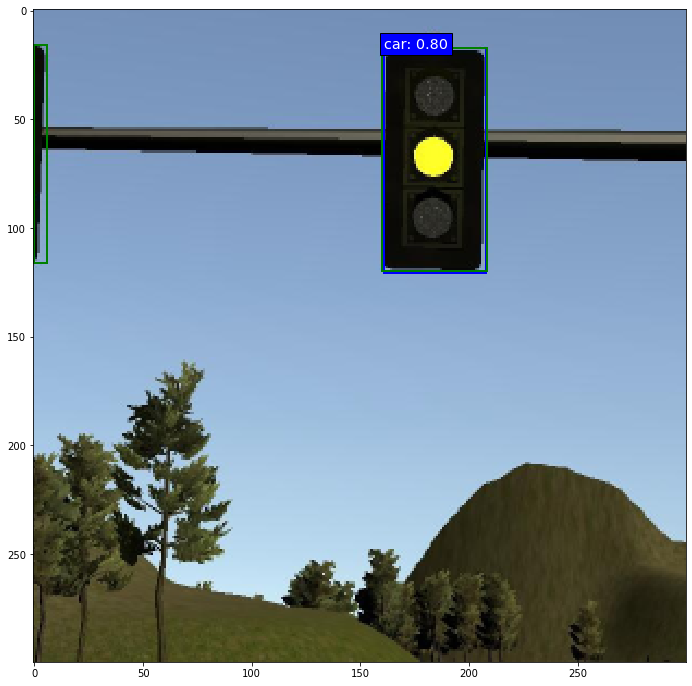

In [28]:
# Visualize the predictions.

from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist',
           'traffic_light', 'motorcycle', 'bus', 'stop_sign'] # Just so we can print class names onto the image instead of IDs

# Draw the predicted boxes in blue
for box in y_pred_thresh[i]:
    class_id = box[0]
    confidence = box[1]
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    label = '{}: {:.2f}'.format(classes[int(class_id)], confidence)
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='blue', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in batch_labels[i]:
    class_id = box[0]
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(class_id)])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

Seems as if our sub-sampled weights were doing a good job, sweet. Now we can fine-tune this model on our dataset with 8 classes.